In [ ]:
pip install gdown

In [ ]:
!gdown https://drive.google.com/uc?id=1YolG8YB609WvXGFPF2Q8cvDl3Tqko6fm

Permission denied: https://drive.google.com/uc?id=1YolG8YB609WvXGFPF2Q8cvDl3Tqko6fm
Maybe you need to change permission over 'Anyone with the link'?


### Merge all eda ru categories

In [ ]:
import gensim
from gensim.models import Word2Vec
import numpy as np
from tqdm.notebook import tqdm
import sys
import pandas as pd
import glob
from tqdm.notebook import tqdm

In [ ]:
path = './csv_eda_ru'
all_csv = glob.glob(path + "/*.csv")

df_list = []

for filename in all_csv:
  df = pd.read_csv(filename, index_col=None, header=0)
  df_list.append(df)

df = pd.concat(df_list, axis=0, ignore_index=True)

df.rename(columns={"list_ingrid": "ingreds", "image_url": "img_urls","list_bzu":"bzu","list_resipe":"recipe","recept_link":"url"}, inplace=True)

In [ ]:
df['ingreds'] = df['ingreds'].apply(lambda x: x.replace('[','').replace(']','').replace("'",'').lower())
df['bzu'] = df['bzu'].apply(lambda x: x.replace('[','').replace(']','').replace("'",'').lower())
df['recipe'] = df['recipe'].apply(lambda x: x.replace('[','').replace(']','').replace("'",'').lower())
df.drop(['id'], inplace=True, axis=1)

In [ ]:
df.fillna("", inplace=True)

In [ ]:
df.shape

(42096, 6)

In [ ]:
df.head()

In [ ]:
df.to_pickle('eda_full.pkl')

### Preprocess ingredients

In [31]:
!pip install wget
import wget

udpipe_url = 'https://rusvectores.org/static/models/udpipe_syntagrus.model'

modelfile = wget.download(udpipe_url)

In [27]:
def clean_token(token, misc):
    """
    :param token:
    :param misc:
    :return:
    """
    out_token = token.strip().replace(' ', '')
    if token == 'Файл' and 'SpaceAfter=No' in misc:
        return None
    return out_token


def clean_lemma(lemma, pos, lowercase=True):
    """
    :param lemma:
    :param pos:
    :return:
    """
    out_lemma = lemma.strip().replace(' ', '').replace('_', '')
    if lowercase:
        out_lemma = out_lemma.lower()
    if '|' in out_lemma or out_lemma.endswith('.jpg') or out_lemma.endswith('.png'):
        return None
    if pos != 'PUNCT':
        if out_lemma.startswith('«') or out_lemma.startswith('»'):
            out_lemma = ''.join(out_lemma[1:])
        if out_lemma.endswith('«') or out_lemma.endswith('»'):
            out_lemma = ''.join(out_lemma[:-1])
        if out_lemma.endswith('!') or out_lemma.endswith('?') or out_lemma.endswith(',') \
                or out_lemma.endswith('.'):
            out_lemma = ''.join(out_lemma[:-1])
    return out_lemma

def num_replace(word):
    newtoken = 'x' * len(word)
    nw = newtoken + '_NUM'
    return nw

In [28]:
def process(pipeline, text='Строка', keep_pos=True, keep_punct=False):
    entities = {'PROPN'}
    named = False
    memory = []
    mem_case = None
    mem_number = None
    tagged_propn = []

    # обрабатываем текст, получаем результат в формате conllu:
    processed = pipeline.process(text)

    # пропускаем строки со служебной информацией:
    content = [l for l in processed.split('\n') if not l.startswith('#')]

    # извлекаем из обработанного текста леммы, тэги и морфологические характеристики
    tagged = [w.split('\t') for w in content if w]

    for t in tagged:
        if len(t) != 10:
            continue
        (word_id, token, lemma, pos, xpos, feats, head, deprel, deps, misc) = t
        token = clean_token(token, misc)
        lemma = clean_lemma(lemma, pos)
        if not lemma or not token:
            continue
        if pos in entities:
            if '|' not in feats:
                tagged_propn.append('%s_%s' % (lemma, pos))
                continue
            morph = {el.split('=')[0]: el.split('=')[1] for el in feats.split('|')}
            if 'Case' not in morph or 'Number' not in morph:
                tagged_propn.append('%s_%s' % (lemma, pos))
                continue
            if not named:
                named = True
                mem_case = morph['Case']
                mem_number = morph['Number']
            if morph['Case'] == mem_case and morph['Number'] == mem_number:
                memory.append(lemma)
                if 'SpacesAfter=\\n' in misc or 'SpacesAfter=\s\\n' in misc:
                    named = False
                    past_lemma = '::'.join(memory)
                    memory = []
                    tagged_propn.append(past_lemma + '_PROPN ')
            else:
                named = False
                past_lemma = '::'.join(memory)
                memory = []
                tagged_propn.append(past_lemma + '_PROPN ')
                tagged_propn.append('%s_%s' % (lemma, pos))
        else:
            if not named:
                if pos == 'NUM' and token.isdigit():  # Заменяем числа на xxxxx той же длины
                    lemma = num_replace(token)
                tagged_propn.append('%s_%s' % (lemma, pos))
            else:
                named = False
                past_lemma = '::'.join(memory)
                memory = []
                tagged_propn.append(past_lemma + '_PROPN ')
                tagged_propn.append('%s_%s' % (lemma, pos))

    if not keep_punct:
        tagged_propn = [word for word in tagged_propn if word.split('_')[1] != 'PUNCT']
    if not keep_pos:
        tagged_propn = [word.split('_')[0] for word in tagged_propn]
    return tagged_propn

In [32]:
!pip install ufal.udpipe
from ufal.udpipe import Model, Pipeline
import os
import re

print('\nLoading the model...', file=sys.stderr)
modelfile = 'udpipe_syntagrus.model'
if not os.path.isfile(modelfile):
    udpipe_model_url = 'https://rusvectores.org/static/models/udpipe_syntagrus.model'
    udpipe_filename = udpipe_model_url.split('/')[-1]
    print('UDPipe model not found. Downloading...', file=sys.stderr)
    wget.download(udpipe_model_url)
ufal_model = Model.load(modelfile)
process_pipeline = Pipeline(ufal_model, 'tokenize', Pipeline.DEFAULT, Pipeline.DEFAULT, 'conllu')


Loading the model...


In [33]:
def tag_ud(text='Текст нужно передать функции в виде строки!', process_pipeline=process_pipeline, keep_pos=True):
    output = []
    for line in tqdm(text):
        line_proc = process(process_pipeline, text=line, keep_pos=keep_pos)
        output.append(' '.join(line_proc))
    return output

In [ ]:
df['ingreds_udpipe'] = tag_ud(df['ingreds'])

### Computing mean vectors for recipes

word2vec

In [ ]:
mean_vector = []

for lst in tqdm(df['ingreds_udpipe'], desc='Word2Vec'):
  vectors = []
  for word in lst.split():
    if word in model_w2v.vocab:
      vectors.append(model_w2v[word])
  mean_vector.append(np.mean(vectors, axis=0))

df['word2vec_mean'] = mean_vector

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


fasttext

In [ ]:
mean_vector = []

for lst in tqdm(df['ingreds'], desc='FastText'):
  vectors = []
  for ing in lst.split(', '):
    for word in ing.split():
      if word in model_fasttext.vocab:
        vectors.append(model_fasttext[word])
  mean_vector.append(np.mean(vectors, axis=0))

df['fasttext_mean'] = mean_vector

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


elmo

In [ ]:
mean_vector = []

for lst in tqdm(df['ingreds'], desc='Elmo'):
  data = re.split('\W+', lst)
  mean_vector.append(elmo([data])[0])

df['elmo_mean'] = mean_vector

In [ ]:
df.head()

,name,ingreds,img_urls,bzu,recipe,url,elmo_mean,ingreds_udpipe,word2vec_mean,fasttext_mean
0,Классический гаспачо,"помидоры, лук репчатый, консервированный перец...",['//eda.ru/img/eda/-x900i/s2.eda.ru/StaticCont...,"калорийность 124 ккал, белки 2,1 грамм, жиры 8...",1. нарежьте на небольшие кусочки половину поми...,https://eda.ru/recepty/supy/klassicheskij-gasp...,"[0.35613972, -0.16420478, -0.74799836, 0.34920...",помидор_NOUN лук_NOUN репчатый_ADJ консервиров...,"[-0.19614118, -0.30456144, 0.110873364, 0.1411...","[0.23766057, -0.14722513, 0.26281512, 0.322688..."
1,Сырный суп с цветной капустой,"морковь, сыр чеддер, сельдерей, лук репчатый, ...",['//eda.ru/img/eda/-x900i/s1.eda.ru/StaticCont...,"калорийность 210 ккал, белки 13,1 грамм, жиры ...","1. морковь очистить и крупно порезать, сельдер...",https://eda.ru/recepty/supy/sirnij-sup-s-cvetn...,"[0.15020154, -0.069539025, -0.82773656, 0.4166...",морковь_NOUN сырой_NOUN чеддер_NOUN сельдерей_...,"[-0.1304116, -0.22534479, 0.049045254, 0.06448...","[0.20389909, -0.14750314, 0.32450354, 0.371789..."
2,Крем-суп из белых грибов с трюфельными крутонами,"белые грибы, шампиньоны, лук-шалот, корень сел...",['//eda.ru/img/eda/-x900i/s2.eda.ru/StaticCont...,"калорийность 572 ккал, белки 10,7 грамм, жиры ...","1. очистите картофель, сельдерей и лук шалот, ...",https://eda.ru/recepty/supy/krem-sup-iz-belih-...,"[0.024114396, -0.007425511, -0.25696534, 0.363...",белый_ADJ гриб_NOUN шампиньон_NOUN лук_NOUN -ш...,"[-0.09315017, -0.24910887, 0.114956595, 0.0796...","[0.15275306, -0.20246969, 0.2546173, 0.2965490..."
3,Грибная похлебка с тмином,"картофель, свежие шампиньоны, стебель сельдере...",['//eda.ru/img/eda/-x900i/s1.eda.ru/StaticCont...,"калорийность 212 ккал, белки 5,9 грамм, жиры 1...",1. лук мелко порубить. в кастрюле разогреть сл...,https://eda.ru/recepty/supy/gribnaja-pohlebka-...,"[-0.119115, 0.031564657, -0.8966865, 0.2403267...",картофель_NOUN свежий_ADJ шампиньон_NOUN стебе...,"[-0.16256933, -0.23612441, 0.17289527, 0.14424...","[0.18881986, -0.26113236, 0.30056414, 0.295603..."
4,Борщ украинский,"мясо, картофель, белокочанная капуста, свекла,...",['//eda.ru/img/eda/-x900i/s1.eda.ru/StaticCont...,"калорийность 333 ккал, белки 20,8 грамм, жиры ...","1. сварить мясной бульон и процедить., 2. очищ...",https://eda.ru/recepty/supy/borsch-ukrainskij-...,"[0.06660799, -0.051458877, -1.0013746, 0.13847...",мясо_NOUN картофель_NOUN белокочанный_ADJ капу...,"[-0.20623636, -0.30649135, 0.19879593, 0.11318...","[0.1925591, -0.24328007, 0.31592736, 0.3619329..."


In [ ]:
df.to_pickle("./eda_vectors.pkl")

In [ ]:
!gdown https://drive.google.com/uc?id=1Nt2gOdBO_VRurQVJmQB7sIahRQZ9XyEI

Downloading...
From: https://drive.google.com/uc?id=1Nt2gOdBO_VRurQVJmQB7sIahRQZ9XyEI
To: /content/eda_vectors.pkl
361MB [00:01, 202MB/s]


In [ ]:
df = pd.read_pickle("./eda_vectors.pkl")

### Installation

In [5]:
import gensim
from gensim.models import Word2Vec
import numpy as np
from tqdm.notebook import tqdm
import sys
import pandas as pd
import glob
from tqdm.notebook import tqdm

In [67]:
!pip install wget
import wget

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=c6cb1e414bf71bc86513da9c4ab4afed8532fbf90e60cb31ac55f335c03b4170
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [68]:
model_w2v = 'http://vectors.nlpl.eu/repository/20/183.zip'
m = wget.download(model_w2v)

In [69]:
!unzip 183.zip -d word2vec_183

Archive:  183.zip
  inflating: word2vec_183/meta.json  
  inflating: word2vec_183/model.bin  
  inflating: word2vec_183/model.txt  
  inflating: word2vec_183/README     


In [6]:
model_word2vec = gensim.models.KeyedVectors.load_word2vec_format('word2vec_183/model.bin', binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [ ]:
model_fasttext = 'http://vectors.nlpl.eu/repository/20/181.zip'
m = wget.download(model_fasttext)

In [72]:
!unzip 181.zip -d fasttext_181

Archive:  181.zip
  inflating: word2vec_181/meta.json  
  inflating: word2vec_181/model.model  
  inflating: word2vec_181/model.model.vectors_ngrams.npy  
  inflating: word2vec_181/model.model.vectors.npy  
  inflating: word2vec_181/model.model.vectors_vocab.npy  
  inflating: word2vec_181/README     


In [7]:
model_fasttext = gensim.models.KeyedVectors.load('fasttext_181/model.model')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


elmo

In [ ]:
#!pip install tensorflow-gpu==1.14.0
!pip install deeppavlov

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
import tensorflow
print(tensorflow.__version__)

1.15.2


In [ ]:
# from deeppavlov.deep import find_config
# from deeppavlov.core.commands.infer import build_model
# config_path = find_config('drive/My Drive/Dish-id/elmo/elmo_ru_wiki.json')
# model_elmo = build_model(config_path, load_trained = True, download = True)

In [8]:
from deeppavlov.models.embedders.elmo_embedder import ELMoEmbedder

elmo = ELMoEmbedder("http://files.deeppavlov.ai/deeppavlov_data/elmo_ru-wiki_600k_steps.tar.gz")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package perluniprops to /root/nltk_data...
[nltk_data]   Package perluniprops is already up-to-date!
[nltk_data] Downloading package nonbreaking_prefixes to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package nonbreaking_prefixes is already up-to-date!


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


### Different word models

In [36]:
from abc import ABC, abstractmethod
from scipy.spatial.distance import cosine

class MatchModel(ABC):
  def __init__(self, mean_recipes, word_model):
    self.mean_recipes = mean_recipes
    self.word_model = word_model

  @abstractmethod
  def mean_embedding(self, ingred_list):
    pass

  def most_similar(self, ingred_list, k):
    mean_vector = self.mean_embedding(ingred_list)
    cos_sim = self.mean_recipes.apply(lambda v: cosine(v, mean_vector)).\
                  sort_values()[:k]
    return cos_sim, cos_sim.index


class Word2Vec(MatchModel):
  def __init__(self, mean_recipes, word_model):
    super().__init__(mean_recipes, word_model)

  def mean_embedding(self, ingred_list):
    words = ' '.join(tag_ud(ingred_list)).split()
    vectors = [self.word_model[word] for word in words]
    return np.mean(vectors, axis=0)

class FastText(MatchModel):
  def __init__(self, mean_recipes, word_model):
    super().__init__(mean_recipes, word_model)

  def mean_embedding(self, ingred_list):
    words = ' '.join(tag_ud(ingred_list, keep_pos=False)).split()
    vectors = [self.word_model[word] for word in words if word in self.word_model.vocab]
    return np.mean(vectors, axis=0)

class Elmo(MatchModel):
  def __init__(self, mean_recipes, word_model):
    super().__init__(mean_recipes, word_model)

  def mean_embedding(self, ingred_list):
    return self.word_model([ingred_list])[0]

### Img to ingred model

In [10]:
from abc import ABC, abstractmethod
from PIL import Image

class IngredModel(ABC):
  @abstractmethod
  def predict(self, img_path):
    pass


class DenseChefNet(IngredModel):
  def __init__(self, model, threshold=0.25):
    self.model = model
    self.threshold = threshold

  def predict(self, img_path):
    img = Image.open(img_path)
    img = transform_val(img).to(device).unsqueeze(0)
    
    with torch.no_grad():
      ingred_pred = self.model(img) > self.threshold
    
    ingred_pred = ingred_pred.nonzero()[:, 1].tolist()
    ingred_pred = [id2word[ing+1] for ing in ingred_pred]
    ingred_pred = [en2ru[ing] for ing in ingred_pred]

    return ingred_pred

### Pipeline

### Test

In [ ]:
!gdown https://drive.google.com/uc?id=11gUIVJrOmdc0edYF9eHT11DrhYFnuxM2
!gdown https://drive.google.com/uc?id=1Oj-tq8L0mU34kjIo7DWjG9uxeXZPMrkP
!gdown https://drive.google.com/uc?id=1M7ZLpVn0-E1X1HJhPERwwwphlQ3mtOGQ

Downloading...
From: https://drive.google.com/uc?id=11gUIVJrOmdc0edYF9eHT11DrhYFnuxM2
To: /content/clean_ingred.txt
100% 1.44k/1.44k [00:00<00:00, 1.28MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Oj-tq8L0mU34kjIo7DWjG9uxeXZPMrkP
To: /content/rus_clean_ingred.txt
100% 2.88k/2.88k [00:00<00:00, 5.60MB/s]
Downloading...
From: https://drive.google.com/uc?id=1M7ZLpVn0-E1X1HJhPERwwwphlQ3mtOGQ
To: /content/recipes.json
6.27MB [00:00, 196MB/s]


In [ ]:
!gdown https://drive.google.com/uc?id=1Usn-XgKql3aUAQcbt5S4-BEM7Zg8Jgwq
!unzip -qq AllRecipes_images.zip
!rm AllRecipes_images.zip

Downloading...
From: https://drive.google.com/uc?id=1Usn-XgKql3aUAQcbt5S4-BEM7Zg8Jgwq
To: /content/AllRecipes_images.zip
4.02GB [00:43, 92.5MB/s]


In [11]:
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_sequence
from collections import defaultdict
import matplotlib.pyplot as plt
from PIL import Image
import pickle
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from torch.optim import lr_scheduler
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [12]:
df = pd.read_pickle("eda_vectors.pkl")

In [13]:
from collections import defaultdict
with open('data/recipes.json', 'rb') as f:
  recipe_list = json.loads(f.read())
recipe_data = defaultdict(dict)
for recipe in recipe_list:
  recipe_data[recipe['id']] = recipe

with open('data/clean_ingred.txt', 'r') as f:
  clean_ingredients = list(f.read().split('\n'))

In [14]:
en2ru = {}
with open('data/clean_ingred.txt', 'r') as f:
  en=f.readlines()
with open('data/rus_clean_ingred.txt', 'r') as f:
  ru=f.readlines()

for e, r in zip(en, ru):
  en2ru[e.rstrip('\n')] = r.rstrip('\n')
with open('en2ru_ing.json', 'w') as f:
  json.dump(en2ru, f)

In [15]:
id2word = defaultdict()
for i, ingr in enumerate(clean_ingredients):
  id2word[i+1] = ingr

word2id = {v:k for k,v in id2word.items()}
def words2ids(ingreds):
  return [word2id[ing] for ing in ingreds]

In [16]:
transform_val = transforms.Compose([
  transforms.Resize((250, 250)),
  transforms.CenterCrop((224, 224)),
  transforms.ToTensor(),
  transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

In [43]:
import random
from random import randint
from scipy.spatial.distance import cosine

val_images = os.listdir('AllRecipes_images/val')

def predict_image(img_path, df, ingred_model, word_model, k=10, threshold=0.25):
  ingred_pred = ingred_model.predict(img_path)
  cos_sim, best_indices = word_model.most_similar(ingred_pred, k)

  return cos_sim, df.loc[best_indices]

In [18]:
%%capture
model = models.densenet161(pretrained=True)
num_feat = model.classifier.in_features
model.classifier = nn.Sequential(
        nn.Linear(num_feat, 1024),
        nn.BatchNorm1d(1024),
        nn.ReLU(),
        nn.Linear(1024, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Linear(512, len(word2id)),
        nn.Sigmoid()
    )
model.to(device)
model.load_state_dict(torch.load('/content/drive/My Drive/Dish-id/model_densenet/epoch_27.pth'))
model.eval()

chefnet = DenseChefNet(model)

In [23]:
elmo_model = Elmo(df['elmo_mean'], elmo)
word2vec_model = Word2Vec(df['word2vec_mean'], model_word2vec)
fasttext_model = FastText(df['fasttext_mean'], model_fasttext)

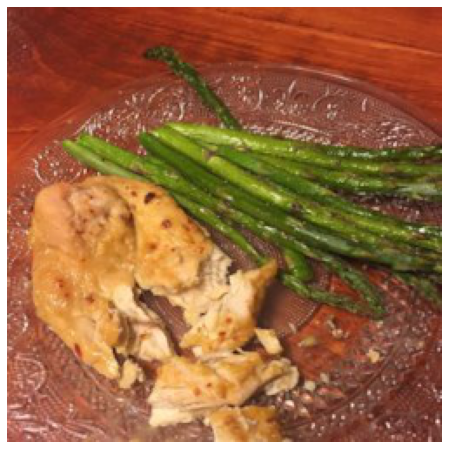

1) Лук-порей под корочкой
	лук-порей, оливковое масло, бекон, сыр грюйер, сливочное масло, соль
	https://eda.ru/recepty/zakuski/luk-porej-pod-korochkoj-16355
2) Салат с луком и оливками
	лук репчатый, оливки, соль, уксус, растительное масло
	https://eda.ru/recepty/salaty/salat-s-lukom-olivkami-21071
3) Хрустящий порей
	лук-порей, арахисовое масло
	https://eda.ru/recepty/zakuski/hrustjaschij-porej-27301
4) Венгерская закуска из творога (Корозот)
	творог, пиво, лук репчатый, паприка, сливочное масло
	https://eda.ru/recepty/zakuski/vengerskaja-zakuska-iz-tvoroga-korozot-46540
5) Лук-порей в сырном соусе
	лук-порей, сливочное масло, молоко, чеснок, твердый сыр
	https://eda.ru/recepty/osnovnye-blyuda/luk-porej-v-sirnom-souse-32973
6) Луковая закуска «Студенческая»
	лук репчатый, сосиски, кетчуп, майонез, растительное масло
	https://eda.ru/recepty/zakuski/lukovaja-zakuska-studencheskaja-31592
7) Слоеные рулетики с луком-пореем
	лук-порей, слоеное тесто, яйцо куриное, соль, сыр робиола, оливк

In [48]:
random.seed(0)
img_name = val_images[randint(0, len(val_images)-1)]
img_path = os.path.join('AllRecipes_images/val', img_name)
img = Image.open(img_path)

plt.figure(figsize=(12,8))
plt.imshow(img)
plt.axis('off')
plt.show()

cos_sim, best_rows = predict_image(img_path, df, chefnet, elmo_model)

for i, row in enumerate(best_rows.iterrows()):
  row = row[1]
  print(f"{i + 1}) {row['name']}")
  print('\t' + row['ingreds'])
  print(f"\t{row['url']}")

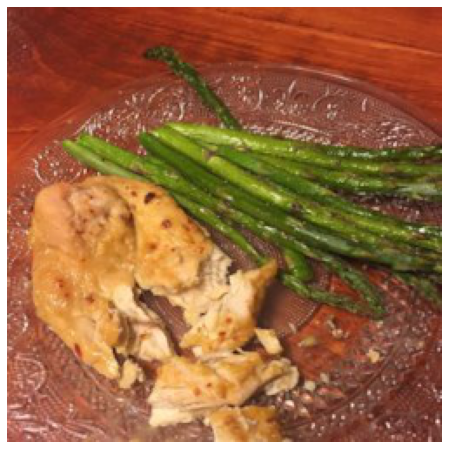


1) Сырное масло
	сливочное масло, сыр
	https://eda.ru/recepty/zakuski/sirnoe-maslo-15448
2) Саганаки
	сливочное масло, лимон, сыр халуми
	https://eda.ru/recepty/zakuski/saganaki-25855
3) Картофель с луком и сливками
	соль, сливки, сыр грюйер, сливочное масло, лук репчатый, оливковое масло, картофель
	https://eda.ru/recepty/zakuski/kartofel-s-lukom-slivkami-16505
4) Лук-порей под корочкой
	лук-порей, оливковое масло, бекон, сыр грюйер, сливочное масло, соль
	https://eda.ru/recepty/zakuski/luk-porej-pod-korochkoj-16355
5) Макарони с чоризо и помидорами
	макароны, оливковое масло, лук репчатый, сахар, сыр грюйер, чоризо, сливочное масло, томатный соус, соль
	https://eda.ru/recepty/pasta-picca/makaroni-s-chorizo-pomidorami-14479
6) Каннеллони с вешенками и рикоттой
	сыр рикотта, вешенки, лук, оливковое масло, паста каннеллони, сыр пармезан, соль, молотый мускатный орех, пшеничная мука, сливочное масло, молоко
	https://eda.ru/recepty/pasta-picca/kannelloni-s-veshenkami-i-rikottoj-40690
7) 

In [49]:
random.seed(0)
img_name = val_images[randint(0, len(val_images)-1)]
img_path = os.path.join('AllRecipes_images/val', img_name)
img = Image.open(img_path)

plt.figure(figsize=(12,8))
plt.imshow(img)
plt.axis('off')
plt.show()

cos_sim, best_rows = predict_image(img_path, df, chefnet, word2vec_model)

for i, row in enumerate(best_rows.iterrows()):
  row = row[1]
  print(f"{i + 1}) {row['name']}")
  print('\t' + row['ingreds'])
  print(f"\t{row['url']}")

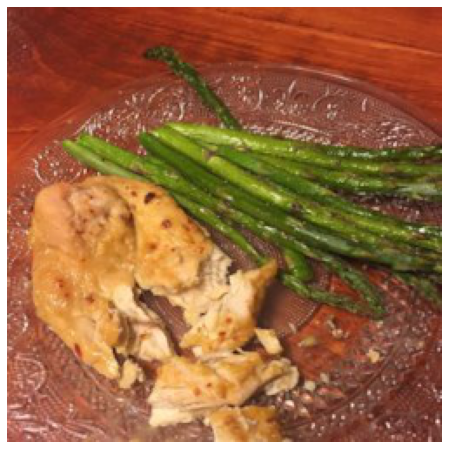


1) Картофель с луком и сливками
	соль, сливки, сыр грюйер, сливочное масло, лук репчатый, оливковое масло, картофель
	https://eda.ru/recepty/zakuski/kartofel-s-lukom-slivkami-16505
2) Томатный соус для равиоли
	соль, сливочное масло, сыр грюйер, сахар, помидоры, лук репчатый, подсолнечное масло
	https://eda.ru/recepty/sousy-marinady/tomatnij-sous-dlja-ravioli-16547
3) Морской гребешок с овощным ризотто
	морские гребешки, цукини, спаржа, лук репчатый, чеснок, белое сухое вино, сыр пармезан, сливки 20%-ные, сливочное масло, растительное масло, оливковое масло, соль, физалис
	https://eda.ru/recepty/osnovnye-blyuda/morskoj-grebeshok-s-ovoshhnim-rizotto-49600
4) Морской гребешок с овощным ризотто и пармезаном
	морские гребешки, цукини, спаржа, лук репчатый, чеснок, белое сухое вино, сыр пармезан, сливки 20%-ные, сливочное масло, растительное масло, оливковое масло, соль, физалис
	https://eda.ru/recepty/osnovnye-blyuda/morskoj-grebeshok-s-ovoshhnim-rizotto-i-parmezanom-49892
5) Паста с прош

In [50]:
random.seed(0)
img_name = val_images[randint(0, len(val_images)-1)]
img_path = os.path.join('AllRecipes_images/val', img_name)
img = Image.open(img_path)

plt.figure(figsize=(12,8))
plt.imshow(img)
plt.axis('off')
plt.show()

cos_sim, best_rows = predict_image(img_path, df, chefnet, fasttext_model)

for i, row in enumerate(best_rows.iterrows()):
  row = row[1]
  print(f"{i + 1}) {row['name']}")
  print('\t' + row['ingreds'])
  print(f"\t{row['url']}")